In [1]:
import numpy as np 
import pandas as pd 
import sys, requests, shutil, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pyplot import subplots

import glob
import warnings

import cv2

import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Lambda
from tensorflow.keras.optimizers import Adam, RMSprop

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score

import tensorflow as tf
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

print('Keras version:', keras.__version__)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
warnings.simplefilter('default')

Keras version: 2.2.4-tf
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6634596125526985812
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4594383815833331435
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7353174158671549360
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15928269210
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12818194638128554179
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [12]:
#from tensorflow.keras.utils import multi_gpu_model

In [13]:
#from tensorflow.keras.applications.vgg16 import VGG16
#from keras.preprocessing import image
#from keras.applications.vgg16 import preprocess_input, decode_predictions

### data prep

In [14]:
mini_dataset_flag = False # set =True for debugging purpose
batch_size = 64
batch_size_predict = 256
input_shape = (150, 150)
top_model_weights_path = "top-modified-Xception-model-weights.hdf5"
if mini_dataset_flag: top_model_weights_path = "mini-" + top_model_weights_path

load
1. n_cat
2. data_path
3. train_info
4. dev_info

In [15]:
n_cat = 6401
data_path = './datasets/train/'

h5_file_name = 'D0527-ex-rare60-reduce-top-labels-processed_data.h5'
if mini_dataset_flag: h5_file_name = 'mini-' + h5_file_name
data_load = pd.HDFStore(h5_file_name)
train_info = data_load['train_info']
dev_info = data_load['dev_info']
data_load.close()

In [16]:
print(len(train_info))
train_info.head()

932274


,url,landmark_id,filename,label,one_hot
id,,,,,
49567a7236b170ba,https://upload.wikimedia.org/wikipedia/commons...,27,./datasets/train/49567a7236b170ba.jpg,0,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
350c35dd0e716f5d,https://upload.wikimedia.org/wikipedia/commons...,27,./datasets/train/350c35dd0e716f5d.jpg,0,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
c74313b74dd3195d,https://upload.wikimedia.org/wikipedia/commons...,27,./datasets/train/c74313b74dd3195d.jpg,0,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
8323df4b0689d343,https://upload.wikimedia.org/wikipedia/commons...,27,./datasets/train/8323df4b0689d343.jpg,0,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
5ffdeed07f56f8aa,https://upload.wikimedia.org/wikipedia/commons...,27,./datasets/train/5ffdeed07f56f8aa.jpg,0,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."


In [17]:
train_info = train_info.sample(frac=1)
print(len(train_info))
train_info.head()

932274


,url,landmark_id,filename,label,one_hot
id,,,,,
8186679eae4550e1,https://upload.wikimedia.org/wikipedia/commons...,41647,./datasets/train/8186679eae4550e1.jpg,1339,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
821e206ab7f1dcf7,https://upload.wikimedia.org/wikipedia/commons...,60332,./datasets/train/821e206ab7f1dcf7.jpg,1922,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
80fb1cc7ffcedcc2,https://upload.wikimedia.org/wikipedia/commons...,171683,./datasets/train/80fb1cc7ffcedcc2.jpg,5438,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
bc55699892800de0,https://upload.wikimedia.org/wikipedia/commons...,87080,./datasets/train/bc55699892800de0.jpg,2809,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
74c604852ee58d8a,https://upload.wikimedia.org/wikipedia/commons...,61559,./datasets/train/74c604852ee58d8a.jpg,1973,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."


In [18]:
print(len(dev_info))
dev_info.head()

233026


,url,landmark_id,filename
id,,,
ed7a897e2b7977ee,https://upload.wikimedia.org/wikipedia/commons...,27,./datasets/train/ed7a897e2b7977ee.jpg
70fa6dfd6ae8fa0a,https://upload.wikimedia.org/wikipedia/commons...,27,./datasets/train/70fa6dfd6ae8fa0a.jpg
083f4ecd174e5114,https://upload.wikimedia.org/wikipedia/commons...,27,./datasets/train/083f4ecd174e5114.jpg
1aced71eaac3a0bb,https://upload.wikimedia.org/wikipedia/commons...,27,./datasets/train/1aced71eaac3a0bb.jpg
bafe7a417b7bc113,https://upload.wikimedia.org/wikipedia/commons...,27,./datasets/train/bafe7a417b7bc113.jpg


In [19]:
dev_info = dev_info.sample(frac=1)
print(len(dev_info))
dev_info.head()

233026


,url,landmark_id,filename
id,,,
eb92e7a7d06223f6,https://upload.wikimedia.org/wikipedia/commons...,139565,./datasets/train/eb92e7a7d06223f6.jpg
a9c8058d396f8d65,https://upload.wikimedia.org/wikipedia/commons...,110873,./datasets/train/a9c8058d396f8d65.jpg
d84ea7149fa6005f,https://upload.wikimedia.org/wikipedia/commons...,31413,./datasets/train/d84ea7149fa6005f.jpg
5128d4f1c0239d04,https://upload.wikimedia.org/wikipedia/commons...,47918,./datasets/train/5128d4f1c0239d04.jpg
a149de80f61e40d2,https://upload.wikimedia.org/wikipedia/commons...,148332,./datasets/train/a149de80f61e40d2.jpg


In [20]:
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse=True, n_values=n_cat)
label_encoder.fit_transform(train_info['landmark_id'].values)
one_hot_encoder.fit_transform(train_info['label'].values.reshape(-1, 1))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:331: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)]'.
  warnings.warn(msg, DeprecationWarning)


<932274x6401 sparse matrix of type '<class 'numpy.float64'>'
	with 932274 stored elements in Compressed Sparse Row format>

### ImageNet info

### Image i/o and image data augmentaition

In [21]:
def load_images(info, input_shape = input_shape):
    input_shape = tuple(input_shape)
    imgs = np.zeros((len(info), input_shape[0], input_shape[1], 3))

    for i in range(len(info)):
        fname = info.iloc[i]['filename']
        try:
            img = cv2.cvtColor(
                  cv2.resize(cv2.imread(fname),input_shape),
                  cv2.COLOR_BGR2RGB)
        except:
            warnings.warn('Warning: could not read image: '+ fname +
                          '. Use black img instead.')
            img = np.zeros((input_shape[0], input_shape[1], 3))
        imgs[i,:,:,:] = img
    
    return imgs

In [22]:
def load_cropped_images(info, crop_p=0.2, crop='random'):
    new_res = np.array([int(input_shape[0]*(1+crop_p)), int(input_shape[1]*(1+crop_p))])
    if crop == 'random':
        cx0 = np.random.randint(new_res[0] - input_shape[0], size=len(info))
        cy0 = np.random.randint(new_res[1] - input_shape[1], size=len(info))
    else:
        if crop == 'central':
            cx0, cy0 = (new_res - input_shape) // 2                
        if crop == 'upper left':
            cx0, cy0 = 0, 0
        if crop == 'upper right':
            cx0, cy0 = new_res[1] - input_shape[1], 0
        if crop == 'lower left':
            cx0, cy0 = 0, new_res[0] - input_shape[0]
        if crop=='lower right':
            cx0, cy0 = new_res - input_shape        
        cx0 = np.repeat(np.expand_dims(cx0, 0), len(info))
        cy0 = np.repeat(np.expand_dims(cy0, 0), len(info))

    cx1 = cx0 + input_shape[0]
    cy1 = cy0 + input_shape[1]
    
    raw_imgs = load_images(info, input_shape=tuple(new_res))
    
    cropped_imgs = np.zeros((len(info), input_shape[0], input_shape[1], 3))
    for ind in range(len(info)):
        cropped_imgs[ind,:,:,:] = raw_imgs[ind,
                                           cy0[ind]:cy1[ind],
                                           cx0[ind]:cx1[ind], :]
    
    return cropped_imgs

In [23]:
def get_image_gen(info_arg, 
                  shuffle=True, 
                  image_aug=True, 
                  eq_dist=False, 
                  n_ref_imgs=16, 
                  crop_prob=0.5, 
                  crop_p=0.25,
                 batch_size = 256):
    if image_aug:
        datagen = ImageDataGenerator(
            rotation_range=4.,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.5,
            channel_shift_range=25,
            horizontal_flip=True,
            fill_mode='nearest')
        
        if crop_prob > 0:
            datagen_crop = ImageDataGenerator(
                rotation_range=4.,
                shear_range=0.2,
                zoom_range=0.1,
                channel_shift_range=20,
                horizontal_flip=True,
                fill_mode='nearest')
        
    count = len(info_arg)
    while True:
        if eq_dist:
            def sample(df):
                return df.sample(min(n_ref_imgs, len(df)))
            info = info_arg.groupby('landmark_id', group_keys=False).apply(sample)
        else:
            info = info_arg
        print('Generate', len(info), 'for the next round.')
        
        #shuffle data
        if shuffle and count >= len(info):
            info = info.sample(frac=1)
            count = 0
            
        # load images
        for ind in range(0,len(info), batch_size):
            count += batch_size

            y = info['landmark_id'].values[ind:(ind+batch_size)]
            
            if np.random.rand() < crop_prob:
                imgs = load_cropped_images(info.iloc[ind:(ind+batch_size)], 
                                           crop_p=crop_p*np.random.rand() + 0.01, 
                                           crop='random')
                if image_aug:
                    cflow = datagen_crop.flow(imgs, 
                                              y, 
                                              batch_size=imgs.shape[0], 
                                              shuffle=False)
                    imgs, y = next(cflow)                    
            else:
                imgs = load_images(info.iloc[ind:(ind+batch_size)])
                if image_aug:
                    cflow = datagen.flow(imgs, 
                                       y, 
                                       batch_size=imgs.shape[0], 
                                       shuffle=False)
                    imgs, y = next(cflow)             

            imgs = preprocess_input(imgs)
    
            y_l = label_encoder.transform(y[y>=0.])        
            y_oh = np.zeros((len(y), n_cat))
            y_oh[y >= 0., :] = one_hot_encoder.transform(y_l.reshape(-1,1)).todense()
                    
            yield imgs, y_oh

In [24]:
train_gen = get_image_gen(train_info , 
                          image_aug = True,
                          eq_dist=False, 
                          n_ref_imgs=50, 
                          crop_prob=0.5, 
                          crop_p=0.25,
                          batch_size = batch_size)

/opt/anaconda3/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


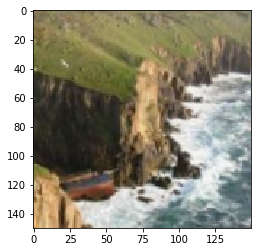

In [33]:
X_example, y_example = next(train_gen)
plt.imshow(X_example[1,:,:,:]/2. + 0.5)
#plt.imshow(tt)

In [26]:
validation_gen = get_image_gen(dev_info, 
                          image_aug = False,
                          eq_dist=False, 
                          crop_prob=0, 
                          crop_p=0,
                          batch_size = batch_size)

In [27]:
y_example

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### The model

In [34]:
def batch_GAP(y_t, y_p):
    pred_cat = tf.argmax(y_p, axis=-1)    
    y_t_cat = tf.argmax(y_t, axis=-1) * tf.cast(
        tf.reduce_sum(y_t, axis=-1), tf.int64)
    
    n_pred = tf.shape(pred_cat)[0]
    is_c = tf.cast(tf.equal(pred_cat, y_t_cat), tf.float32)

    GAP = tf.reduce_mean(
          tf.cumsum(is_c) * is_c / tf.cast(
              tf.range(1, n_pred + 1), 
              dtype=tf.float32))
    
    return GAP

In [35]:
K.clear_session()

In [36]:
#base_model = VGG16(include_top=False, weights='imagenet', input_shape=list(input_shape) + [3])
x_model = Xception(input_shape=list(input_shape) + [3],  weights='imagenet', include_top=False)

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py:60: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  elif not isinstance(value, collections.Sized):


In [37]:
gm_exp = tf.Variable(3., dtype=tf.float32)
def generalized_mean_pool_2d(X):
    pool = (tf.reduce_mean(tf.abs(X**(gm_exp)), 
                           axis=[1,2], 
                           keepdims=False)+1.e-8)**(1./gm_exp)
    return pool

In [38]:

X_feat = Input(x_model.output_shape[1:])

lambda_layer = Lambda(generalized_mean_pool_2d)
lambda_layer.trainable_weights.extend([gm_exp])
X = lambda_layer(X_feat)
X = Dropout(0.05)(X)
X = Activation('relu')(X)
#X = Dense(256, activation='relu')(X)
X = Dense(n_cat, activation='softmax')(X)

top_model = Model(inputs=X_feat, outputs=X)

top_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5, 5, 2048)]      0         
_________________________________________________________________
lambda (Lambda)              (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
activation (Activation)      (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 6401)              13115649  
Total params: 13,115,649
Trainable params: 13,115,649
Non-trainable params: 0
_________________________________________________________________


In [39]:
X_image = Input(list(input_shape) + [3])

X_f = x_model(X_image)
X_f = top_model(X_f)

model = Model(inputs=X_image, outputs=X_f)

for layer in x_model.layers[:85]:
    layer.trainable = False  

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
model (Model)                (None, 6401)              13115649  
Total params: 33,977,129
Trainable params: 24,745,961
Non-trainable params: 9,231,168
_________________________________________________________________


In [40]:
#model = multi_gpu_model(model, gpus=8)

In [41]:
def binary_crossentropy_n_cat(y_t, y_p):
    return keras.metrics.binary_crossentropy(y_t, y_p) * n_cat

In [42]:
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.0001), 
              metrics=['accuracy', batch_GAP])


print ('Compilation done.')
model.summary()

Compilation done.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
model (Model)                (None, 6401)              13115649  
Total params: 33,977,129
Trainable params: 24,745,961
Non-trainable params: 9,231,168
_________________________________________________________________


In [43]:
checkpoint1 = ModelCheckpoint(top_model_weights_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
#checkpoint2 = ModelCheckpoint(top_model_weights_path, monitor='batch_GAP', verbose=1, save_best_only=True, save_weights_only=True)
callbacks_list = [checkpoint1]
np.warnings.filterwarnings('ignore')

In [ ]:
model.fit_generator(train_gen, 
                    steps_per_epoch=len(train_info) // batch_size/2, 
                    epochs=30, 
                    validation_data=validation_gen,
                    validation_steps=len(dev_info) // batch_size/2,
                    callbacks=callbacks_list)

Epoch 1/30
7282/7283 [============================>.] - ETA: 0s - loss: 6.4252 - accuracy: 0.0881 - batch_GAP: 0.0162Generate 233026 for the next round.

Epoch 00001: val_accuracy improved from -inf to 0.16320, saving model to top-modified-Xception-model-weights.hdf5
7283/7283 [==============================] - 3698s 508ms/step - loss: 6.4250 - accuracy: 0.0881 - batch_GAP: 0.0162 - val_loss: 5.3366 - val_accuracy: 0.1632 - val_batch_GAP: 0.0367
Epoch 2/30
7282/7283 [============================>.] - ETA: 0s - loss: 4.9607 - accuracy: 0.2033 - batch_GAP: 0.0541Generate 233026 for the next round.

Epoch 00002: val_accuracy improved from 0.16320 to 0.23128, saving model to top-modified-Xception-model-weights.hdf5
7283/7283 [==============================] - 3772s 518ms/step - loss: 4.9607 - accuracy: 0.2033 - batch_GAP: 0.0541 - val_loss: 4.7631 - val_accuracy: 0.2313 - val_batch_GAP: 0.0670
Epoch 3/30
7282/7283 [============================>.] - ETA: 0s - loss: 4.2035 - accuracy: 0.2831

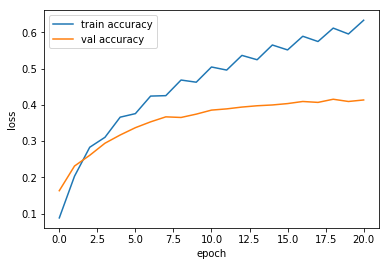

In [2]:
train_acc = np.array([0.0881, 0.2032 , 0.2831 , 0.3105 ,0.3661 , 0.3759 , 0.4243 , 0.4255 , 0.4686 , 0.4626 , 0.5046 ,0.4961 ,0.5366, 0.5246 ,0.5653,0.5517 , 0.5894 , 0.5749, 0.6119 ,0.5957, 0.6336 ])
val_acc = np.array([0.1632 , 0.2313 , 0.2609,0.2942,0.3169,0.3371 ,  0.3532 , 0.3670 ,0.3653 ,0.3745 , 0.3856 ,0.3890 ,0.3940 , 0.3976 ,0.3998,0.4036  ,0.4094,0.4069,0.4156 ,0.4094 ,0.4136   ])
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['train accuracy', 'val accuracy'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


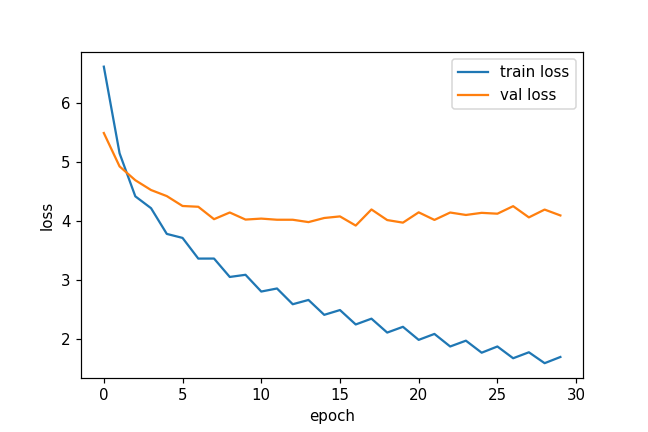

In [32]:
%matplotlib inline
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.legend(['train loss', 'val loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

<IPython.core.display.Javascript object>


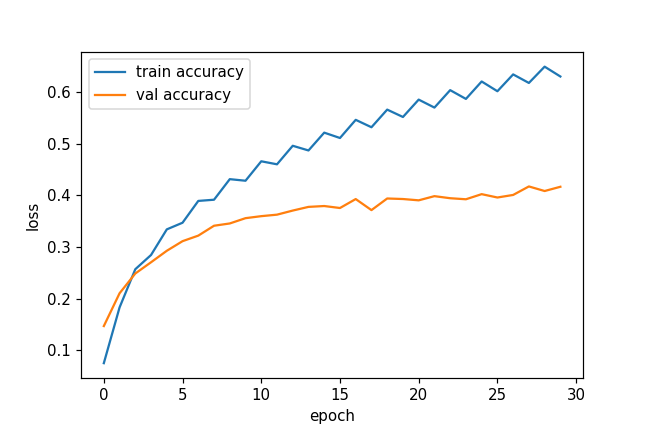

In [33]:

plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.legend(['train accuracy', 'val accuracy'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

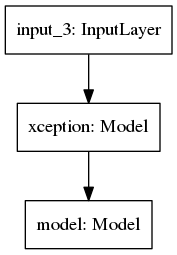

In [35]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [36]:
print(model.history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [37]:
print(model.history.history)

{'loss': [6.622137917245333, 5.152255861647541, 4.421898704005289, 4.2203228140080284, 3.784268854657249, 3.7162589426144095, 3.365386120131297, 3.366010218748234, 3.053741101440626, 3.0905225133398284, 2.8062726126824544, 2.8581473488704887, 2.5908984941065527, 2.663560164624578, 2.4109802917893792, 2.492151469691972, 2.247636349070898, 2.3459184809436873, 2.1099763774087767, 2.2077854334546956, 1.9862439360675739, 2.0869076563960722, 1.8738977659159326, 1.97243956718801, 1.7684199939575702, 1.874013183569656, 1.67442240054869, 1.775603570806183, 1.590736084625535, 1.6955949072979906], 'accuracy': [0.07473311, 0.18277702, 0.25683314, 0.28441876, 0.33401775, 0.34691232, 0.38916922, 0.3914939, 0.4313406, 0.42828333, 0.46596637, 0.46012118, 0.4960373, 0.48695162, 0.52149546, 0.5110982, 0.546295, 0.53194296, 0.5661256, 0.55182016, 0.58549917, 0.57004756, 0.6038494, 0.58684605, 0.6206377, 0.60173094, 0.63436013, 0.61778283, 0.6493463, 0.63029057], 'val_loss': [5.496212528944343, 4.92963022